# Blackjack-v0

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import gym
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

### Use Environment

In [2]:
env = gym.make("Blackjack-v1")
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

00:00:18 [INFO] env: <BlackjackEnv<Blackjack-v1>>
00:00:18 [INFO] _action_space: None
00:00:18 [INFO] _observation_space: None
00:00:18 [INFO] _reward_range: None
00:00:18 [INFO] _metadata: None
00:00:18 [INFO] _has_reset: False
00:00:18 [INFO] entry_point: gym.envs.toy_text:BlackjackEnv
00:00:18 [INFO] reward_threshold: None
00:00:18 [INFO] nondeterministic: False
00:00:18 [INFO] max_episode_steps: None
00:00:18 [INFO] order_enforce: True
00:00:18 [INFO] kwargs: {'sab': True, 'natural': False}
00:00:18 [INFO] namespace: None
00:00:18 [INFO] name: Blackjack
00:00:18 [INFO] version: 1


### On-policy Monte Carlo

Monte Carlo prediction

In [3]:
def ob2state(observation):
    return observation[0], observation[1], int(observation[2])

def evaluate_action_monte_carlo(env, policy, episode_num=500000):
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # play an episode
        state_actions = []
        observation = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # end of episode
        g = reward # return
        for state, action in state_actions:
            c[state][action] += 1.
            q[state][action] += (g - q[state][action]) / c[state][action]
    return q

In [4]:
policy = np.zeros((22, 11, 2, 2))
policy[20:, :, :, 0] = 1 # stand when >=20
policy[:20, :, :, 1] = 1 # hit when <20

q = evaluate_action_monte_carlo(env, policy) # action value
v = (q * policy).sum(axis=-1) # state value

In [5]:
def play_policy(env, policy=None):
    observation, reward, done = env.reset(), 0., False
    episode_reward, elapsed_steps = 0., 0
    logging.debug('observation = %s', observation)
    while True:
        logging.debug('player = %s, dealer = %s', env.player, env.dealer)
        if policy is None:
            action = env.action_space.sample()
        else:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
        logging.debug('action = %s', action)
        observation, reward, done, _ = env.step(action)
        logging.debug('observation = %s, reward = %s, done = %s',
                observation, reward, done)
        episode_reward += reward
        elapsed_steps += 1
        if done:
            break
    return episode_reward, elapsed_steps

episode_reward, elapsed_steps = play_policy(env)
logging.info("episode reward: %.2f", episode_reward)

00:04:38 [DEBUG] observation = (18, 10, False)
00:04:38 [DEBUG] player = [8, 10], dealer = [10, 1]
00:04:38 [DEBUG] action = 1
00:04:38 [DEBUG] observation = (26, 10, False), reward = -1.0, done = True
00:04:38 [INFO] episode reward: -1.00


In [6]:
def plot(data):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    titles = ['without ace', 'with ace']
    have_aces = [0, 1]
    extent = [12, 22, 1, 11]
    for title, have_ace, axis in zip(titles, have_aces, axes):
        dat = data[extent[0]:extent[1], extent[2]:extent[3], have_ace].T
        axis.imshow(dat, extent=extent, origin='lower')
        axis.set_xlabel('player sum')
        axis.set_ylabel('dealer showing')
        axis.set_title(title)

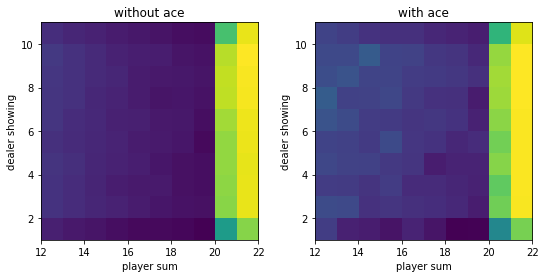

In [7]:
plot(v)

Test Policy

In [8]:
logging.basicConfig(level=logging.INFO, # reset display level to avoid too much output
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [9]:
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_policy(env, policy)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

00:04:43 [DEBUG] observation = (14, 9, False)
00:04:43 [DEBUG] player = [6, 8], dealer = [9, 7]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (22, 9, False), reward = -1.0, done = True
00:04:43 [DEBUG] test episode 0: reward = -1.00, steps = 1
00:04:43 [DEBUG] observation = (18, 10, False)
00:04:43 [DEBUG] player = [10, 8], dealer = [10, 10]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (28, 10, False), reward = -1.0, done = True
00:04:43 [DEBUG] test episode 1: reward = -1.00, steps = 1
00:04:43 [DEBUG] observation = (16, 3, True)
00:04:43 [DEBUG] player = [5, 1], dealer = [3, 2]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (15, 3, False), reward = 0.0, done = False
00:04:43 [DEBUG] player = [5, 1, 9], dealer = [3, 2]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (16, 3, False), reward = 0.0, done = False
00:04:43 [DEBUG] player = [5, 1, 9, 1], dealer = [3, 2]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (26, 3, False)

00:04:43 [DEBUG] observation = (12, 6, False)
00:04:43 [DEBUG] player = [3, 9], dealer = [6, 6]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (14, 6, False), reward = 0.0, done = False
00:04:43 [DEBUG] player = [3, 9, 2], dealer = [6, 6]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (24, 6, False), reward = -1.0, done = True
00:04:43 [DEBUG] test episode 24: reward = -1.00, steps = 2
00:04:43 [DEBUG] observation = (21, 10, True)
00:04:43 [DEBUG] player = [10, 1], dealer = [10, 1]
00:04:43 [DEBUG] action = 0
00:04:43 [DEBUG] observation = (21, 10, True), reward = 0.0, done = True
00:04:43 [DEBUG] test episode 25: reward = 0.00, steps = 1
00:04:43 [DEBUG] observation = (14, 3, False)
00:04:43 [DEBUG] player = [9, 5], dealer = [3, 10]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (15, 3, False), reward = 0.0, done = False
00:04:43 [DEBUG] player = [9, 5, 1], dealer = [3, 10]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (21, 3, False), r

00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (14, 10, True), reward = 0.0, done = False
00:04:43 [DEBUG] player = [1, 1, 1, 1], dealer = [10, 10]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (17, 10, True), reward = 0.0, done = False
00:04:43 [DEBUG] player = [1, 1, 1, 1, 3], dealer = [10, 10]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (19, 10, True), reward = 0.0, done = False
00:04:43 [DEBUG] player = [1, 1, 1, 1, 3, 2], dealer = [10, 10]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (12, 10, False), reward = 0.0, done = False
00:04:43 [DEBUG] player = [1, 1, 1, 1, 3, 2, 3], dealer = [10, 10]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (22, 10, False), reward = -1.0, done = True
00:04:43 [DEBUG] test episode 47: reward = -1.00, steps = 6
00:04:43 [DEBUG] observation = (16, 10, False)
00:04:43 [DEBUG] player = [7, 9], dealer = [10, 10]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (19, 10, False), rew

00:04:43 [DEBUG] observation = (22, 8, False), reward = -1.0, done = True
00:04:43 [DEBUG] test episode 67: reward = -1.00, steps = 1
00:04:43 [DEBUG] observation = (15, 2, False)
00:04:43 [DEBUG] player = [5, 10], dealer = [2, 3]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (23, 2, False), reward = -1.0, done = True
00:04:43 [DEBUG] test episode 68: reward = -1.00, steps = 1
00:04:43 [DEBUG] observation = (10, 2, False)
00:04:43 [DEBUG] player = [7, 3], dealer = [2, 8]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (16, 2, False), reward = 0.0, done = False
00:04:43 [DEBUG] player = [7, 3, 6], dealer = [2, 8]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (26, 2, False), reward = -1.0, done = True
00:04:43 [DEBUG] test episode 69: reward = -1.00, steps = 2
00:04:43 [DEBUG] observation = (13, 10, False)
00:04:43 [DEBUG] player = [3, 10], dealer = [10, 2]
00:04:43 [DEBUG] action = 1
00:04:43 [DEBUG] observation = (23, 10, False), reward = -1.0, done

00:04:44 [DEBUG] action = 1
00:04:44 [DEBUG] observation = (19, 4, False), reward = 0.0, done = False
00:04:44 [DEBUG] player = [5, 8, 3, 3], dealer = [4, 2]
00:04:44 [DEBUG] action = 1
00:04:44 [DEBUG] observation = (22, 4, False), reward = -1.0, done = True
00:04:44 [DEBUG] test episode 88: reward = -1.00, steps = 3
00:04:44 [DEBUG] observation = (18, 10, False)
00:04:44 [DEBUG] player = [10, 8], dealer = [10, 8]
00:04:44 [DEBUG] action = 1
00:04:44 [DEBUG] observation = (23, 10, False), reward = -1.0, done = True
00:04:44 [DEBUG] test episode 89: reward = -1.00, steps = 1
00:04:44 [DEBUG] observation = (15, 6, False)
00:04:44 [DEBUG] player = [5, 10], dealer = [6, 7]
00:04:44 [DEBUG] action = 1
00:04:44 [DEBUG] observation = (24, 6, False), reward = -1.0, done = True
00:04:44 [DEBUG] test episode 90: reward = -1.00, steps = 1
00:04:44 [DEBUG] observation = (19, 7, False)
00:04:44 [DEBUG] player = [9, 10], dealer = [7, 3]
00:04:44 [DEBUG] action = 1
00:04:44 [DEBUG] observation = (20

In [10]:
env.reset()

(15, 4, False)

In [11]:
policy[tuple(env.reset())]

array([], shape=(0, 2, 2), dtype=float64)

#### Monte Carlo update with exploring start

In [12]:
def monte_carlo_with_exploring_start(env, episode_num=500000):
    policy = np.zeros((22, 11, 2, 2))
    policy[:, :, :, 1] = 1.
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # choose initial state randomly
        state = (np.random.randint(12, 22),
                 np.random.randint(1, 11),
                 np.random.randint(2))
        action = np.random.randint(2)
        # play an episode
        env.reset()
        if state[2]: # has ace
            env.player = [1, state[0] - 11]
        else: # no ace
            if state[0] == 21:
                env.player = [10, 9, 2]
            else:
                env.player = [10, state[0] - 10]
        env.dealer[0] = state[1]
        state_actions = []
        while True:
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # end of episode
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
        g = reward # return
        for state, action in state_actions:
            c[state][action] += 1.
            q[state][action] += (g - q[state][action]) / c[state][action]
            a = q[state].argmax()
            policy[state] = 0.
            policy[state][a] = 1.
    return policy, q

In [13]:
policy, q = monte_carlo_with_exploring_start(env)
v = q.max(axis=-1)

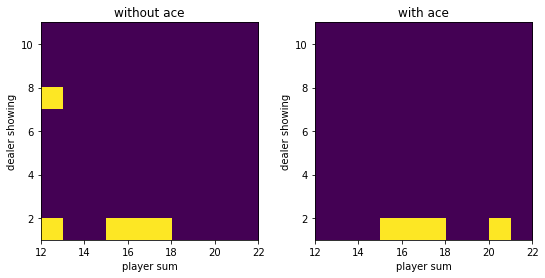

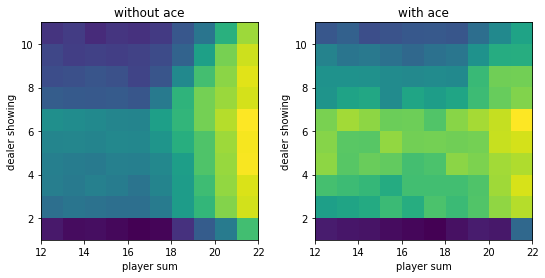

In [14]:
plot(policy.argmax(-1))
plot(v)

Monte Carlo update with soft poicy

In [15]:
def monte_carlo_with_soft(env, episode_num=500000, epsilon=0.1):
    policy = np.ones((22, 11, 2, 2)) * 0.5 # soft policy
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # play an episode
        state_actions = []
        observation = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # end of episode
        g = reward # return
        for state, action in state_actions:
            c[state][action] += 1.
            q[state][action] += (g - q[state][action]) / c[state][action]
            # soft update
            a = q[state].argmax()
            policy[state] = epsilon / 2.
            policy[state][a] += (1. - epsilon)
    return policy, q

In [16]:
policy, q = monte_carlo_with_soft(env)
v = q.max(axis=-1)

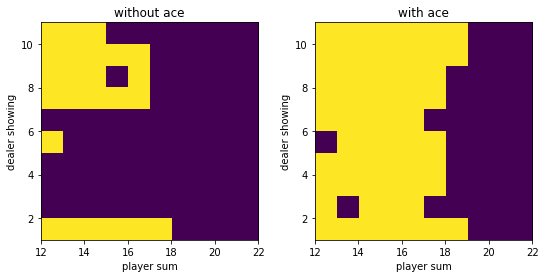

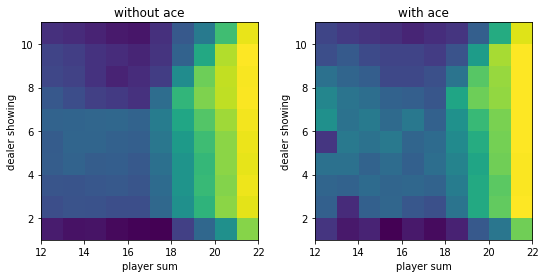

In [17]:
plot(policy.argmax(-1))
plot(v)

Test Policy

In [18]:
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_policy(env, policy)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

00:10:49 [DEBUG] observation = (16, 10, False)
00:10:49 [DEBUG] player = [1, 8], dealer = [10, 8]
00:10:49 [DEBUG] action = 0
00:10:49 [DEBUG] observation = (16, 10, False), reward = -1.0, done = True
00:10:49 [DEBUG] test episode 0: reward = -1.00, steps = 1
00:10:49 [DEBUG] observation = (20, 7, False)
00:10:49 [DEBUG] player = [1, 8], dealer = [7, 10]
00:10:49 [DEBUG] action = 0
00:10:49 [DEBUG] observation = (20, 7, False), reward = 1.0, done = True
00:10:49 [DEBUG] test episode 1: reward = 1.00, steps = 1
00:10:49 [DEBUG] observation = (12, 7, False)
00:10:49 [DEBUG] player = [1, 8], dealer = [7, 2]
00:10:49 [DEBUG] action = 1
00:10:49 [DEBUG] observation = (16, 7, False), reward = 0.0, done = False
00:10:49 [DEBUG] player = [1, 8], dealer = [7, 2]
00:10:49 [DEBUG] action = 1
00:10:49 [DEBUG] observation = (22, 7, False), reward = -1.0, done = True
00:10:49 [DEBUG] test episode 2: reward = -1.00, steps = 2
00:10:49 [DEBUG] observation = (20, 10, False)
00:10:49 [DEBUG] player = [1

00:10:49 [DEBUG] observation = (14, 10, False)
00:10:49 [DEBUG] player = [1, 8], dealer = [10, 10]
00:10:49 [DEBUG] action = 1
00:10:49 [DEBUG] observation = (17, 10, False), reward = 0.0, done = False
00:10:49 [DEBUG] player = [1, 8], dealer = [10, 10]
00:10:49 [DEBUG] action = 0
00:10:49 [DEBUG] observation = (17, 10, False), reward = -1.0, done = True
00:10:49 [DEBUG] test episode 26: reward = -1.00, steps = 2
00:10:49 [DEBUG] observation = (17, 10, False)
00:10:49 [DEBUG] player = [1, 8], dealer = [10, 8]
00:10:49 [DEBUG] action = 0
00:10:49 [DEBUG] observation = (17, 10, False), reward = -1.0, done = True
00:10:49 [DEBUG] test episode 27: reward = -1.00, steps = 1
00:10:49 [DEBUG] observation = (15, 6, False)
00:10:49 [DEBUG] player = [1, 8], dealer = [6, 5]
00:10:50 [DEBUG] action = 0
00:10:50 [DEBUG] observation = (15, 6, False), reward = 1.0, done = True
00:10:50 [DEBUG] test episode 28: reward = 1.00, steps = 1
00:10:50 [DEBUG] observation = (12, 10, False)
00:10:50 [DEBUG] pl

00:10:50 [DEBUG] player = [1, 8], dealer = [5, 10]
00:10:50 [DEBUG] action = 1
00:10:50 [DEBUG] observation = (18, 5, False), reward = 0.0, done = False
00:10:50 [DEBUG] player = [1, 8], dealer = [5, 10]
00:10:50 [DEBUG] action = 0
00:10:50 [DEBUG] observation = (18, 5, False), reward = -1.0, done = True
00:10:50 [DEBUG] test episode 51: reward = -1.00, steps = 2
00:10:50 [DEBUG] observation = (5, 10, False)
00:10:50 [DEBUG] player = [1, 8], dealer = [10, 4]
00:10:50 [DEBUG] action = 1
00:10:50 [DEBUG] observation = (12, 10, False), reward = 0.0, done = False
00:10:50 [DEBUG] player = [1, 8], dealer = [10, 4]
00:10:50 [DEBUG] action = 1
00:10:50 [DEBUG] observation = (19, 10, False), reward = 0.0, done = False
00:10:50 [DEBUG] player = [1, 8], dealer = [10, 4]
00:10:50 [DEBUG] action = 0
00:10:50 [DEBUG] observation = (19, 10, False), reward = 1.0, done = True
00:10:50 [DEBUG] test episode 52: reward = 1.00, steps = 3
00:10:50 [DEBUG] observation = (13, 9, False)
00:10:50 [DEBUG] playe

00:10:50 [DEBUG] observation = (11, 10, False), reward = 0.0, done = False
00:10:50 [DEBUG] player = [1, 8], dealer = [10, 7]
00:10:50 [DEBUG] action = 1
00:10:50 [DEBUG] observation = (12, 10, False), reward = 0.0, done = False
00:10:50 [DEBUG] player = [1, 8], dealer = [10, 7]
00:10:50 [DEBUG] action = 1
00:10:50 [DEBUG] observation = (20, 10, False), reward = 0.0, done = False
00:10:50 [DEBUG] player = [1, 8], dealer = [10, 7]
00:10:50 [DEBUG] action = 0
00:10:50 [DEBUG] observation = (20, 10, False), reward = 1.0, done = True
00:10:50 [DEBUG] test episode 73: reward = 1.00, steps = 4
00:10:50 [DEBUG] observation = (7, 5, False)
00:10:50 [DEBUG] player = [1, 8], dealer = [5, 10]
00:10:50 [DEBUG] action = 1
00:10:50 [DEBUG] observation = (16, 5, False), reward = 0.0, done = False
00:10:50 [DEBUG] player = [1, 8], dealer = [5, 10]
00:10:50 [DEBUG] action = 0
00:10:50 [DEBUG] observation = (16, 5, False), reward = -1.0, done = True
00:10:50 [DEBUG] test episode 74: reward = -1.00, step

00:10:50 [DEBUG] test episode 94: reward = -1.00, steps = 2
00:10:50 [DEBUG] observation = (9, 10, False)
00:10:50 [DEBUG] player = [1, 8], dealer = [10, 10]
00:10:50 [DEBUG] action = 1
00:10:50 [DEBUG] observation = (15, 10, False), reward = 0.0, done = False
00:10:50 [DEBUG] player = [1, 8], dealer = [10, 10]
00:10:50 [DEBUG] action = 0
00:10:50 [DEBUG] observation = (15, 10, False), reward = -1.0, done = True
00:10:50 [DEBUG] test episode 95: reward = -1.00, steps = 2
00:10:50 [DEBUG] observation = (14, 4, False)
00:10:50 [DEBUG] player = [1, 8], dealer = [4, 10]
00:10:50 [DEBUG] action = 0
00:10:50 [DEBUG] observation = (14, 4, False), reward = 1.0, done = True
00:10:50 [DEBUG] test episode 96: reward = 1.00, steps = 1
00:10:50 [DEBUG] observation = (13, 4, False)
00:10:50 [DEBUG] player = [1, 8], dealer = [4, 2]
00:10:50 [DEBUG] action = 0
00:10:50 [DEBUG] observation = (13, 4, False), reward = -1.0, done = True
00:10:50 [DEBUG] test episode 97: reward = -1.00, steps = 1
00:10:50 

### Off-Policy Monte Carlo Update

Monte Carlo evaluation with importance sampling

In [19]:
def evaluate_monte_carlo_importance_sample(env, policy, behavior_policy,
        episode_num=500000):
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # play episode using behavior policy
        state_actions = []
        observation = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n,
                    p=behavior_policy[state])
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # finish the episode
        g = reward # return
        rho = 1. # importance sampling ratio
        for state, action in reversed(state_actions):
            c[state][action] += rho
            q[state][action] += (rho / c[state][action] * (g - q[state][action]))
            rho *= (policy[state][action] / behavior_policy[state][action])
            if rho == 0:
                break # early stop
    return q

In [20]:
policy = np.zeros((22, 11, 2, 2))
policy[20:, :, :, 0] = 1 # stand when >=20
policy[:20, :, :, 1] = 1 # hit when <20
behavior_policy = np.ones_like(policy) * 0.5
q = evaluate_monte_carlo_importance_sample(env, policy, behavior_policy)
v = (q * policy).sum(axis=-1)

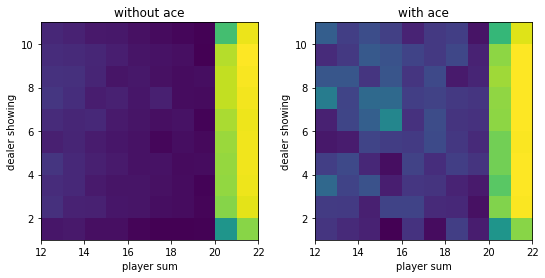

In [21]:
plot(v)

Monte Carlo update with importance sampling

In [22]:
def monte_carlo_importance_sample(env, episode_num=500000):
    policy = np.zeros((22, 11, 2, 2))
    policy[:, :, :, 0] = 1.
    behavior_policy = np.ones_like(policy) * 0.5 # soft policy
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in range(episode_num):
        # play using behavior policy
        state_actions = []
        observation = env.reset()
        while True:
            state = ob2state(observation)
            action = np.random.choice(env.action_space.n,
                    p=behavior_policy[state])
            state_actions.append((state, action))
            observation, reward, done, _ = env.step(action)
            if done:
                break # finish the episode
        g = reward # return
        rho = 1. # importance sampling ratio
        for state, action in reversed(state_actions):
            c[state][action] += rho
            q[state][action] += (rho / c[state][action] * (g - q[state][action]))
            # improve the policy
            a = q[state].argmax()
            policy[state] = 0.
            policy[state][a] = 1.
            if a != action: # early stop
                break
            rho /= behavior_policy[state][action]
    return policy, q

In [23]:
policy, q = monte_carlo_importance_sample(env)
v = q.max(axis=-1)

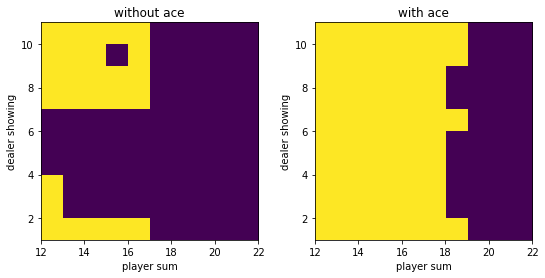

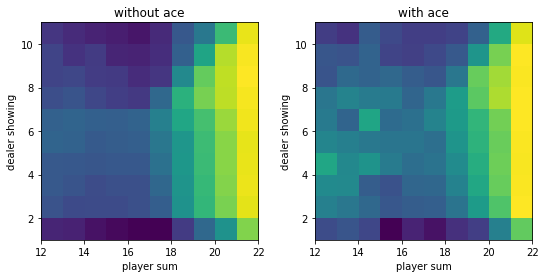

In [24]:
plot(policy.argmax(-1))
plot(v)

Test Policy

In [25]:
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_policy(env, policy)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

00:15:08 [DEBUG] observation = (6, 6, False)
00:15:08 [DEBUG] player = [1, 8], dealer = [6, 10]
00:15:08 [DEBUG] action = 1
00:15:08 [DEBUG] observation = (11, 6, False), reward = 0.0, done = False
00:15:08 [DEBUG] player = [1, 8], dealer = [6, 10]
00:15:08 [DEBUG] action = 1
00:15:08 [DEBUG] observation = (17, 6, False), reward = 0.0, done = False
00:15:08 [DEBUG] player = [1, 8], dealer = [6, 10]
00:15:08 [DEBUG] action = 0
00:15:08 [DEBUG] observation = (17, 6, False), reward = 1.0, done = True
00:15:08 [DEBUG] test episode 0: reward = 1.00, steps = 3
00:15:08 [DEBUG] observation = (13, 10, False)
00:15:08 [DEBUG] player = [1, 8], dealer = [10, 10]
00:15:08 [DEBUG] action = 1
00:15:08 [DEBUG] observation = (19, 10, False), reward = 0.0, done = False
00:15:08 [DEBUG] player = [1, 8], dealer = [10, 10]
00:15:08 [DEBUG] action = 0
00:15:08 [DEBUG] observation = (19, 10, False), reward = -1.0, done = True
00:15:08 [DEBUG] test episode 1: reward = -1.00, steps = 2
00:15:08 [DEBUG] observ

00:15:08 [DEBUG] observation = (19, 10, False)
00:15:08 [DEBUG] player = [1, 8], dealer = [10, 7]
00:15:08 [DEBUG] action = 0
00:15:08 [DEBUG] observation = (19, 10, False), reward = 1.0, done = True
00:15:08 [DEBUG] test episode 23: reward = 1.00, steps = 1
00:15:08 [DEBUG] observation = (13, 10, True)
00:15:08 [DEBUG] player = [1, 8], dealer = [10, 8]
00:15:08 [DEBUG] action = 1
00:15:08 [DEBUG] observation = (20, 10, True), reward = 0.0, done = False
00:15:08 [DEBUG] player = [1, 8], dealer = [10, 8]
00:15:08 [DEBUG] action = 0
00:15:08 [DEBUG] observation = (20, 10, True), reward = 1.0, done = True
00:15:08 [DEBUG] test episode 24: reward = 1.00, steps = 2
00:15:08 [DEBUG] observation = (21, 8, True)
00:15:08 [DEBUG] player = [1, 8], dealer = [8, 1]
00:15:08 [DEBUG] action = 0
00:15:08 [DEBUG] observation = (21, 8, True), reward = 1.0, done = True
00:15:08 [DEBUG] test episode 25: reward = 1.00, steps = 1
00:15:08 [DEBUG] observation = (13, 7, False)
00:15:08 [DEBUG] player = [1, 8

00:15:09 [DEBUG] test episode 47: reward = 1.00, steps = 1
00:15:09 [DEBUG] observation = (12, 6, False)
00:15:09 [DEBUG] player = [1, 8], dealer = [6, 8]
00:15:09 [DEBUG] action = 0
00:15:09 [DEBUG] observation = (12, 6, False), reward = 1.0, done = True
00:15:09 [DEBUG] test episode 48: reward = 1.00, steps = 1
00:15:09 [DEBUG] observation = (9, 3, False)
00:15:09 [DEBUG] player = [1, 8], dealer = [3, 10]
00:15:09 [DEBUG] action = 1
00:15:09 [DEBUG] observation = (19, 3, False), reward = 0.0, done = False
00:15:09 [DEBUG] player = [1, 8], dealer = [3, 10]
00:15:09 [DEBUG] action = 0
00:15:09 [DEBUG] observation = (19, 3, False), reward = -1.0, done = True
00:15:09 [DEBUG] test episode 49: reward = -1.00, steps = 2
00:15:09 [DEBUG] observation = (20, 10, True)
00:15:09 [DEBUG] player = [1, 8], dealer = [10, 8]
00:15:09 [DEBUG] action = 0
00:15:09 [DEBUG] observation = (20, 10, True), reward = 1.0, done = True
00:15:09 [DEBUG] test episode 50: reward = 1.00, steps = 1
00:15:09 [DEBUG] 

00:15:09 [DEBUG] player = [1, 8], dealer = [4, 10]
00:15:09 [DEBUG] action = 1
00:15:09 [DEBUG] observation = (13, 4, False), reward = 0.0, done = False
00:15:09 [DEBUG] player = [1, 8], dealer = [4, 10]
00:15:09 [DEBUG] action = 0
00:15:09 [DEBUG] observation = (13, 4, False), reward = 1.0, done = True
00:15:09 [DEBUG] test episode 73: reward = 1.00, steps = 2
00:15:09 [DEBUG] observation = (13, 9, False)
00:15:09 [DEBUG] player = [1, 8], dealer = [9, 10]
00:15:09 [DEBUG] action = 1
00:15:09 [DEBUG] observation = (14, 9, False), reward = 0.0, done = False
00:15:09 [DEBUG] player = [1, 8], dealer = [9, 10]
00:15:09 [DEBUG] action = 1
00:15:09 [DEBUG] observation = (22, 9, False), reward = -1.0, done = True
00:15:09 [DEBUG] test episode 74: reward = -1.00, steps = 2
00:15:09 [DEBUG] observation = (15, 5, True)
00:15:09 [DEBUG] player = [1, 8], dealer = [5, 10]
00:15:09 [DEBUG] action = 1
00:15:09 [DEBUG] observation = (15, 5, False), reward = 0.0, done = False
00:15:09 [DEBUG] player = 

00:15:09 [DEBUG] test episode 96: reward = -1.00, steps = 2
00:15:09 [DEBUG] observation = (20, 4, False)
00:15:09 [DEBUG] player = [1, 8], dealer = [4, 4]
00:15:09 [DEBUG] action = 0
00:15:09 [DEBUG] observation = (20, 4, False), reward = 0.0, done = True
00:15:09 [DEBUG] test episode 97: reward = 0.00, steps = 1
00:15:09 [DEBUG] observation = (15, 6, False)
00:15:09 [DEBUG] player = [1, 8], dealer = [6, 4]
00:15:09 [DEBUG] action = 0
00:15:09 [DEBUG] observation = (15, 6, False), reward = 1.0, done = True
00:15:09 [DEBUG] test episode 98: reward = 1.00, steps = 1
00:15:09 [DEBUG] observation = (8, 7, False)
00:15:09 [DEBUG] player = [1, 8], dealer = [7, 10]
00:15:09 [DEBUG] action = 1
00:15:09 [DEBUG] observation = (13, 7, False), reward = 0.0, done = False
00:15:09 [DEBUG] player = [1, 8], dealer = [7, 10]
00:15:09 [DEBUG] action = 1
00:15:09 [DEBUG] observation = (16, 7, False), reward = 0.0, done = False
00:15:09 [DEBUG] player = [1, 8], dealer = [7, 10]
00:15:09 [DEBUG] action = 

In [26]:
env.close()